# Font Style Classification with Tesseract

In [148]:
import cv2
import matplotlib.pyplot as plt
import pytesseract
from pytesseract import Output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
BICUBIC = Image.BICUBIC

import random
import json
import logging
import os
from pprint import pprint

from copy import deepcopy
from pathlib import Path

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import clip

## Dataset
I gathered words from a [machine learning translation text corpus](https://sourceforge.net/p/apertium/svn/62515/tree/incubator/apertium-eng-kaz/dev/news.en). For the first 1000 tokens, I created 9 images of each token using 3 font styles (normal, bold, italics) and 3 fonts (calibri, arial, times new roman), and create an 80-10-10 split for the training, validation, and test datasets. I kept the data preprocessing minimal because I was interested in seeing what my models' baseline performance would be when trained on only three fonts.

I approached this OCR problem using word-level formatting as opposed to character-level formatting because it can be difficult for a model to distinguish the feature differences between the different font formats of a single character. For example, the character "c" may not appear too different from "*c*" or "**c**". However, if we use the entire word, the feature differences may become more apparent. 

A random instance of the training dataset can be visualized below.

{'font': 'arial',
 'img_id': 'word_767_arial_bold.png',
 'label': 1,
 'style': 'bold',
 'word': 'the',
 'word_id': 767}


(-0.5, 120.5, 89.5, -0.5)

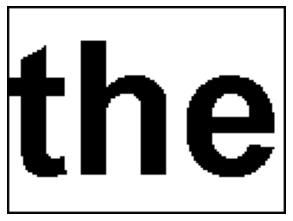

In [149]:
train_path = Path('./data/train.json')
with open(train_path, 'rb') as f:
    train_data = json.load(f)

RAND_EXAMPLE = random.randint(0, len(train_data) - 1)

train_example = train_data[RAND_EXAMPLE]
img_id = train_example['img_id']
img = cv2.imread('./data/images/' + img_id)
pprint(train_example)

plt.figure(figsize = (5, 5))
plt.imshow(img)
plt.axis('off')

## Models
I experimented with 2 models: a model that uses OpenAI CLIP's image encoder, and a simple CNN model. Because CLIP was pretrained to recognize text in images, I was interested in seeing whether I could finetune it to recognize the font style of the text.

In [153]:
class ClipClassifier(torch.nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        clip_dim = 768
        self.clip_model = clip_model
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        self.fc = nn.Linear(clip_dim, 3)

        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, vis_feats, labels=None):
        image_features = self.clip_model.encode_image(vis_feats)  # B x D=768

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        logits = self.fc(F.relu(image_features))

        logit_scale = self.logit_scale.exp()

        logits = logits * logit_scale

        outputs = (logits,)
        if labels is not None:
            loss = self.loss(logits, labels.view(-1))
            outputs = (loss,) + outputs
            return outputs

        return outputs


class SimpleClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(103788, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, 3)
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, vis_feats, labels=None):
        x = self.pool(F.relu(self.conv1(vis_feats)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        logits = self.fc4(x)
        
        outputs = (logits,)
        if labels is not None:
            loss = self.loss(logits, labels.view(-1))
            outputs = (loss,) + outputs
            return outputs

        return outputs

### Using Tesseract

In [162]:
# Use Tesseract to OCR the given doc_file and return a list of detected bounding boxes
def get_doc_bboxes(doc_file, confidence_score):
    bboxes = []
    
    img = cv2.imread(doc_file)
    d = pytesseract.image_to_data(img, output_type=Output.DICT)
    
    n_boxes = len(d['text'])
    for i in range(n_boxes):
        if int(float(d['conf'][i])) > confidence_score:
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            bboxes.append((x, y, x + w, y + h))
    return bboxes


### Loading Trained Models
I trained both ClipClassifier and SimpleClassifier for 5 epochs and a learning rate of 2e-5 and saved the best versions of each model. Both models got >99% accuracy on my validation dataset.

In [154]:
output_dir = './experiments/best_simple_model_2e-5'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


def resize_transform(n_px):
    return Compose([
        Resize((n_px, n_px), interpolation=BICUBIC),
        lambda image: image.convert("RGB"),
        ToTensor(),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])


model_name = '../RN50x16.pt'
clip_model, preprocess = clip.load(model_name, device, jit=False)
print("Using resize transform...")
preprocess = resize_transform(clip_model.visual.input_resolution)
# model = ClipClassifier(clip_model).to(device)
model = SimpleClassifier().to(device)

checkpoint_path = os.path.join(output_dir, 'checkpoint-best/model.pt')
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

print(f"Loading checkpoint from {checkpoint_path}; Epoch: {checkpoint['epoch']}")
model.load_state_dict(checkpoint['state_dict'], strict=False)

model_to_eval = model.module if hasattr(model, 'module') else model

Using resize transform...
Loading checkpoint from ./experiments/best_simple_model_2e-5/checkpoint-best/model.pt; Epoch: 2


## Evaluation using Tesseract
I evaluated my models on a real document by extracting a random word from the front page of the [TextOCR paper](https://arxiv.org/pdf/2105.05486.pdf) using Tesseract. 

Despite high performance on my validation dataset, my CLIP-based model has a bias towards classifying words as "normal" font style, and it classified the bold text in the title (RAND_EXAMPLE=10) and some of the italic text in the Abstract (RAND_EXAMPLE=65) as "normal". Surprisingly, my SimpleClassifier performed much better than my ClipClassifier, and it was correct in classifying the bold title and the italicized Abstract. However, the SimpleClassifier would sometimes misclassify normal text as italicized, and it would also sometimes classify short, 2-3 length words with normal font as being bold. Both models had trouble with colored text or text that wasn't completely black, and they would classify these as italic. 

My results could be improved if I augmented my training dataset by removing noise from the images and giving the text a variety of colors. I would also pad the edges of the images for shorter words to prevent them from appearing zoomed in and to keep the format consistent among all words. It is important to do these preprocessing steps for the training dataset in order to encapsulate a wide range of word formats instead of preprocessing the test data to force it to fit the specific mold of the training data. For example, when converting the gray text in the watermark into black text, this sometimes gave the text a more bold look. Instead, I should include in the training dataset words of varying levels of gray and different colors.

The predictions of my SimpleClassifier given 3 random words from the document are shown below. The 3 chosen words are displayed with blue boxes in the document image.

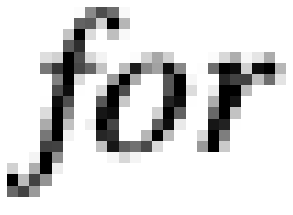

Predicted font style: italic


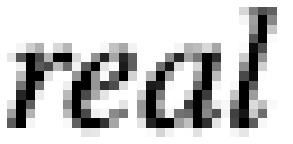

Predicted font style: italic


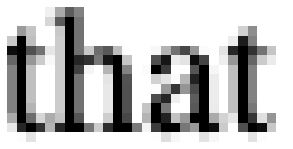

Predicted font style: normal


(-0.5, 1140.5, 1477.5, -0.5)

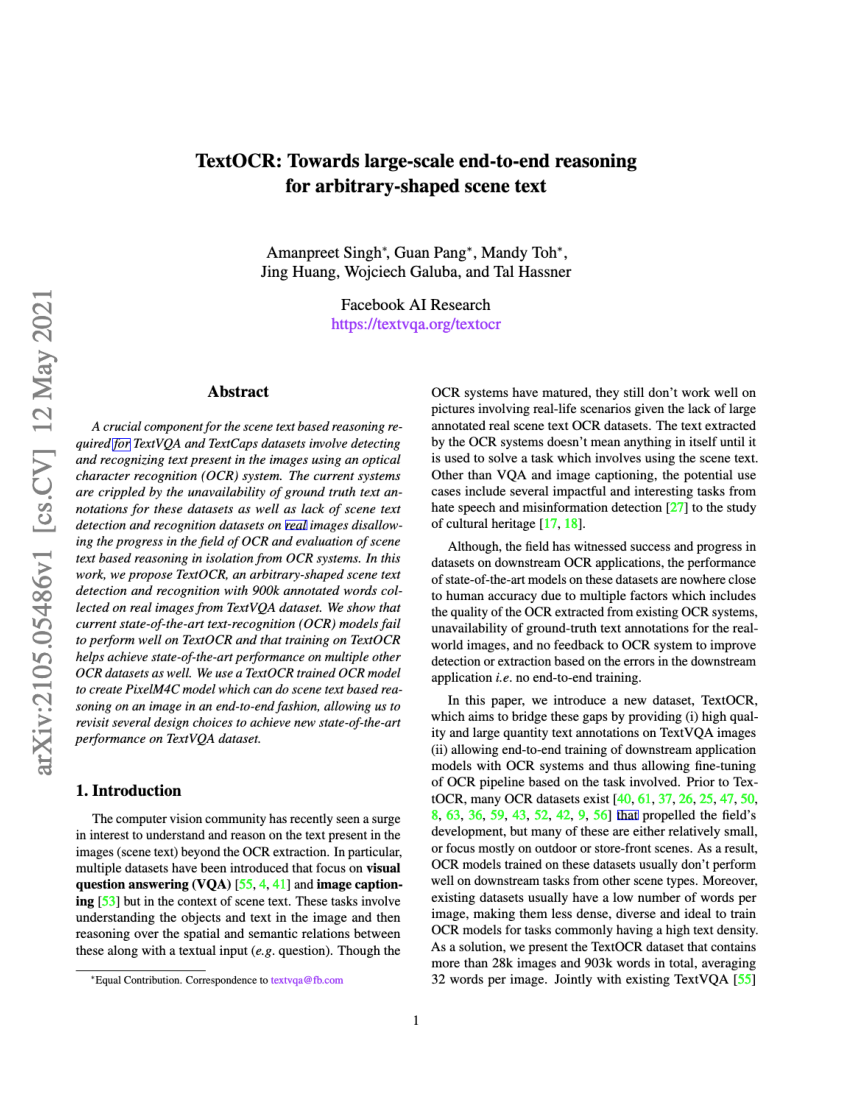

In [161]:
model_to_eval.eval()

img = cv2.imread('./document.png')
doc_img = img.copy()
label_list = ['normal', 'bold', 'italic']
bboxes = get_doc_bboxes('./document.png', 60)

for i in range(3):
    RAND_EXAMPLE = random.randint(0, len(bboxes) - 1)

    x1, y1, x2, y2 = bboxes[RAND_EXAMPLE]
    word_img = img[int(y1):int(y2) + 1, int(x1):int(x2) + 1, :]
    
    # This makes the text look too bold
    # _, word_img = cv2.threshold(word_img, 180, 255, cv2.THRESH_BINARY)

    # Visualize word in document image
    plt.figure(figsize = (5, 5))
    plt.imshow(word_img)
    plt.axis('off')
    plt.show()

    word_img = Image.fromarray(word_img)
    vis_feats = preprocess(word_img)
    outputs = model(vis_feats.unsqueeze(0))
    predicted = torch.argmax(outputs[0].detach(), dim=1)
    print('Predicted font style:', label_list[predicted])

    doc_img = cv2.rectangle(doc_img, (x1, y1), (x2, y2), (0, 0, 255), 1)

plt.figure(figsize = (20, 20))
plt.imshow(doc_img)
plt.axis('off')